# Feature Based Panoramic Image Stitching

Посмотрим на изображения

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

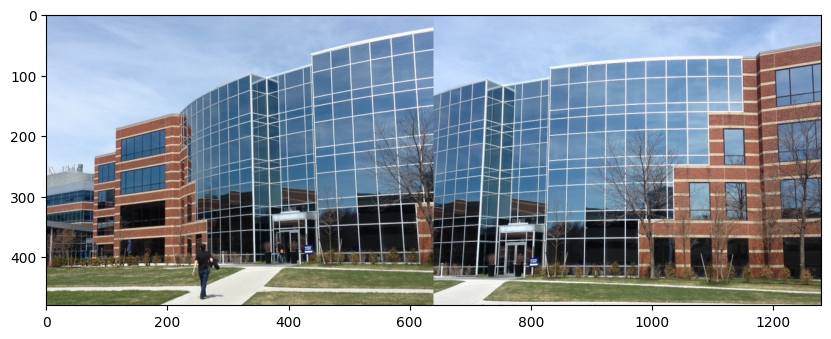

In [2]:
img1 = cv.imread("building1/building1.jpg")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.imread("building1/building2.jpg")
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

figure = plt.figure(figsize=(10, 8))
plt.imshow(np.concatenate((img1, img2), axis=1))

С помощью детектора ORB определяем ключевые точки

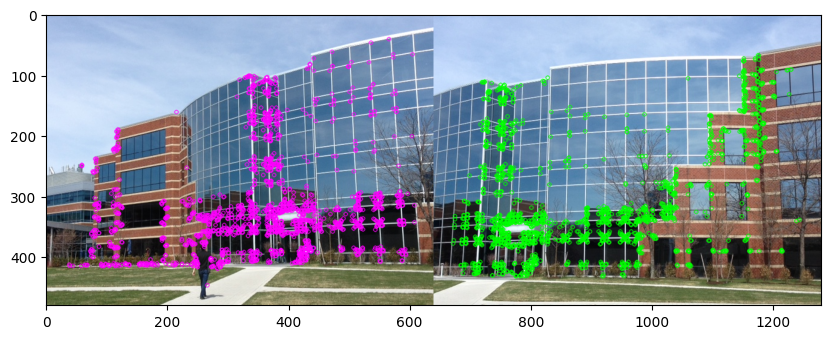

In [3]:
orb = cv.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

img1_kp = cv.drawKeypoints(img1, keypoints1, None, (255, 0, 255))
img2_kp = cv.drawKeypoints(img2, keypoints2, None, (0, 255, 0))

figure = plt.figure(figsize=(10, 8))
plt.imshow(np.concatenate( (img1_kp, img2_kp), axis=1))

In [4]:
print("Descriptor of the first keypoint for first image: ")
print(descriptors1[0])
print("Descriptor of the first keypoint for second image: ")
print(descriptors2[0])

Descriptor of the first keypoint for first image: 
[128 134  56  89  48  47  85 191  95  47  54  24 182  51 138  92 151  10
  76   8  34  44  97  55 239 223  48 112  80 200 192  41]
Descriptor of the first keypoint for second image: 
[105 223  28 108  58 142  86 191 229   8 174 108 246 115  34  80 135  34
 108 104 232  43  67  63 234 255  36  90  90 130 200  11]


In [5]:
def draw_matches(img1, keypoints1, img2, keypoints2, matches):
  r1, c1 = img1.shape[:2]
  r2, c2 = img2.shape[:2]

  # Create a blank image with the size of the first image + second image
  output_img = np.zeros((max([r1, r2]), c1+c2, 3), dtype='uint8')
  output_img[:r1, :c1, :] = img1 #np.dstack([img1, img1, img1])
  output_img[:r2, c1:c1+c2, :] = img2 #np.dstack([img2, img2, img2])

  for match in matches:
    img1_idx = match.queryIdx
    img2_idx = match.trainIdx
    (x1, y1) = keypoints1[img1_idx].pt
    (x2, y2) = keypoints2[img2_idx].pt

    # Draw circles on the keypoints
    cv.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
    cv.circle(output_img, (int(x2)+c1,int(y2)), 4, (0, 255, 255), 1)

    # Connect the same keypoints
    cv.line(output_img, (int(x1),int(y1)), (int(x2)+c1,int(y2)), (0, 255, 255), 1)

  return output_img

Сопоставление ключевых точек на двух изображениях

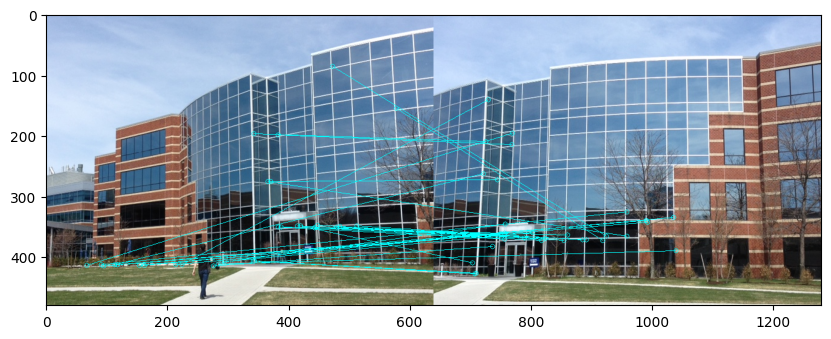

In [6]:
# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv.BFMatcher_create(cv.NORM_HAMMING)

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

all_matches = []
for m, n in matches:
  all_matches.append(m)

img3 = draw_matches(img1, keypoints1, img2, keypoints2, all_matches[:30])

figure = plt.figure(figsize=(10, 8))
plt.imshow(img3)

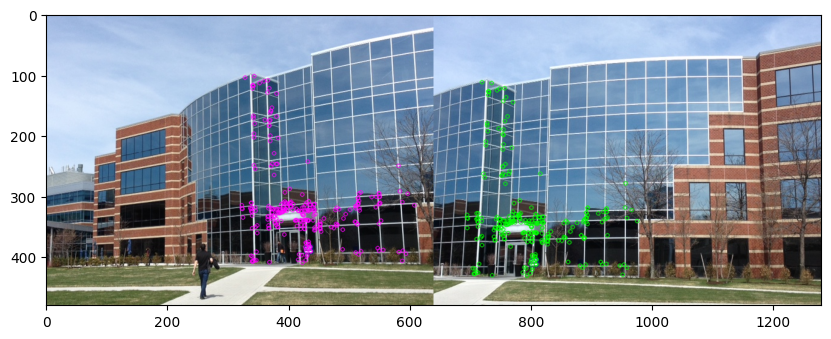

In [7]:
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)

img1_kp = cv.drawKeypoints(img1, [keypoints1[m.queryIdx] for m in good], None, (255, 0, 255))
img2_kp = cv.drawKeypoints(img2, [keypoints2[m.trainIdx] for m in good], None, (0, 255, 0))

figure = plt.figure(figsize=(10, 8))
plt.imshow(np.concatenate( (img1_kp, img2_kp), axis=1))

Склеивание изображений

In [8]:
def warpImages(img1, img2, H):
  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view
  list_of_points_2 = cv.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

  translation_dist = [-x_min, -y_min]

  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv.warpPerspective( img2, H_translation.dot(H), (x_max-x_min, y_max-y_min) )
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

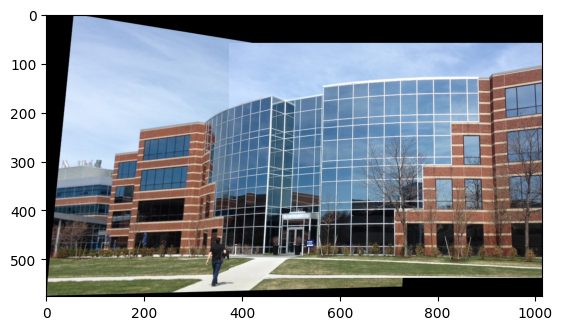

In [9]:
MIN_MATCH_COUNT = 10 # Set minimum match condition

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Вычисление матрицы гомографии
    M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

    result = warpImages(img2, img1, M)

    plt.imshow(result)

Функция для склеивания изображений

In [35]:
from typing import List

def many_image_stitching(images: List[np.ndarray], coef: float) -> np.ndarray:
    
    orb = cv.ORB_create(nfeatures=2000)
    bf = cv.BFMatcher_create(cv.NORM_HAMMING)

    MIN_MATCH_COUNT = 15
    
    img1 = images[0]
    for i in range(1, len(images)):
        img2 = images[i]
        keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
        keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

        matches = bf.knnMatch(descriptors1, descriptors2, k=2)
        
        good = []
        for m, n in matches:
            if m.distance < coef * n.distance:
                good.append(m)

        if len(good) > MIN_MATCH_COUNT:
            src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
            dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

            M, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

            result = warpImages(img2, img1, M)
        img1 = result
    return result

Изображения из папки building1

In [36]:
img1 = cv.imread("building1/building1.jpg")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.imread("building1/building2.jpg")
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.imread("building1/building3.jpg")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
img4 = cv.imread("building1/building4.jpg")
img4 = cv.cvtColor(img4, cv.COLOR_BGR2RGB)
img5 = cv.imread("building1/building5.jpg")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

images = [img1, img2, img3, img4, img5]


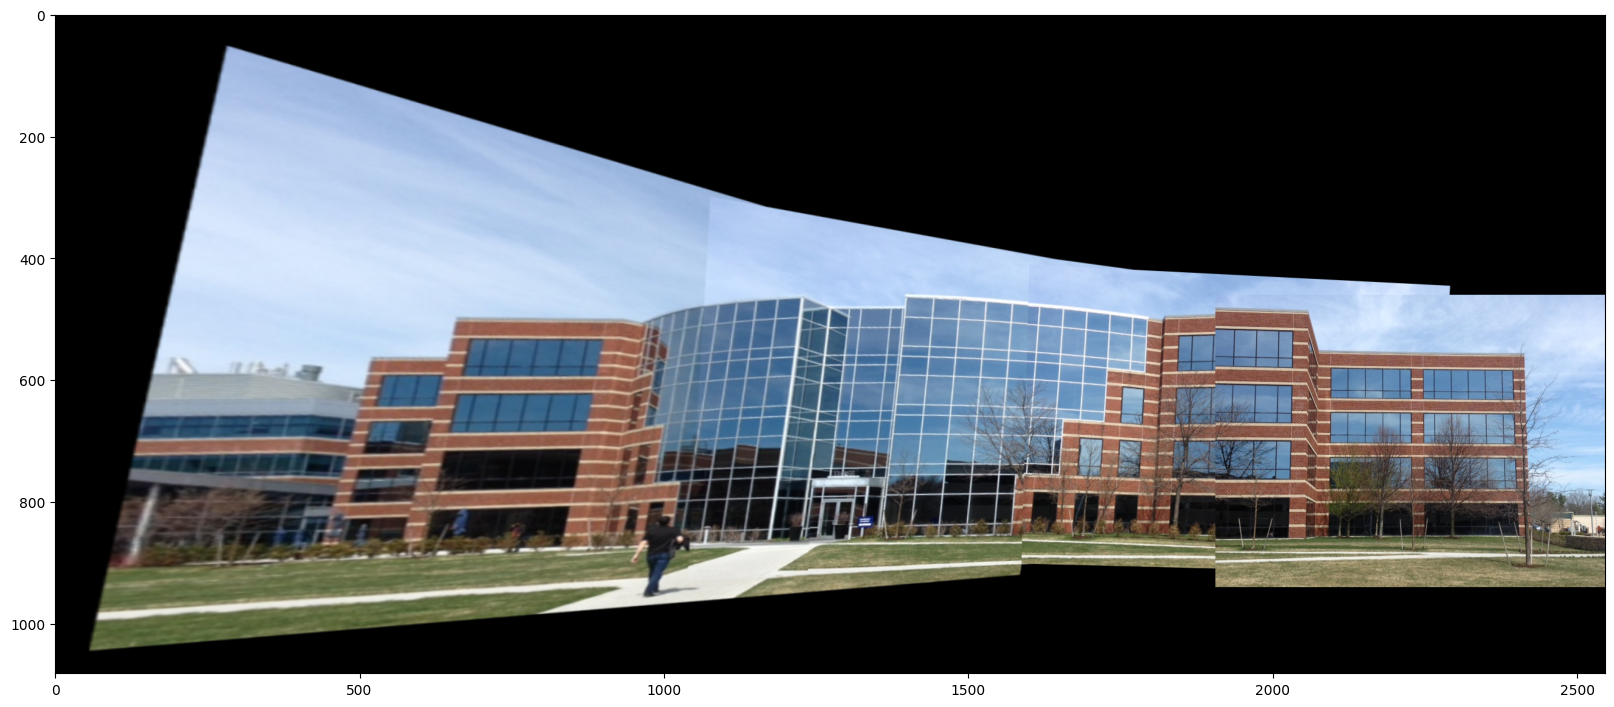

In [37]:
figure = plt.figure(figsize=(20, 10))
result = many_image_stitching(images, coef = 0.6)
plt.imshow(result)

Изображения из папки building2

In [38]:
img1 = cv.imread("building2/dsc_2705.jpg")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.imread("building2/dsc_2706.jpg")
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.imread("building2/dsc_2707.jpg")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
img4 = cv.imread("building2/dsc_2708.jpg")
img4 = cv.cvtColor(img4, cv.COLOR_BGR2RGB)

images = [img1, img2, img3, img4]

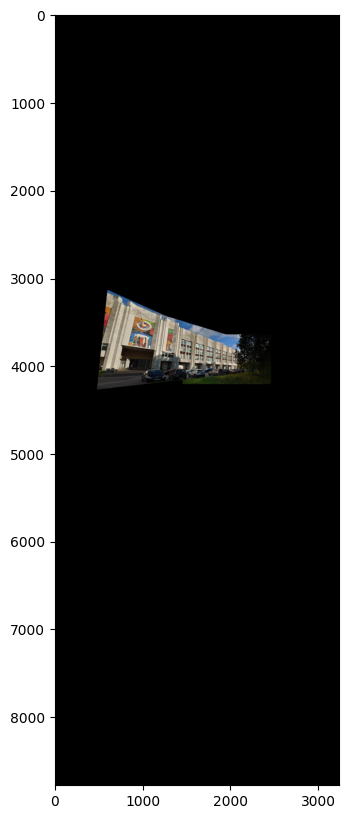

In [40]:
figure = plt.figure(figsize=(20, 10))
result = many_image_stitching(images, coef=0.6)
plt.imshow(result)

Изображения из папки building3

In [21]:
img1 = cv.imread("building3/dsc_2722.jpg")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.imread("building3/dsc_2723.jpg")
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.imread("building3/dsc_2724.jpg")
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
img4 = cv.imread("building3/dsc_2725.jpg")
img4 = cv.cvtColor(img4, cv.COLOR_BGR2RGB)
img5 = cv.imread("building3/dsc_2726.jpg")
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

images = [img1, img2, img3, img4, img5]

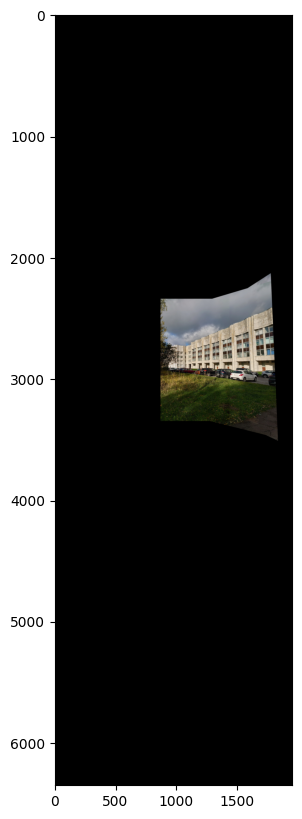

In [31]:
figure = plt.figure(figsize=(20, 10))
result = many_image_stitching(images, coef=0.6)
plt.imshow(result)